Bayesian Neural Network

Importing Libraries

In [1]:
from warnings import filterwarnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import random
import theano
import theano.tensor as T
from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from matplotlib import cm

In [2]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")

In [3]:
from sklearn.datasets import make_gaussian_quantiles

X, Y = make_gaussian_quantiles(cov=3.,
                                 n_samples=1500, n_features=2,
                                 n_classes=4, random_state=42)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)

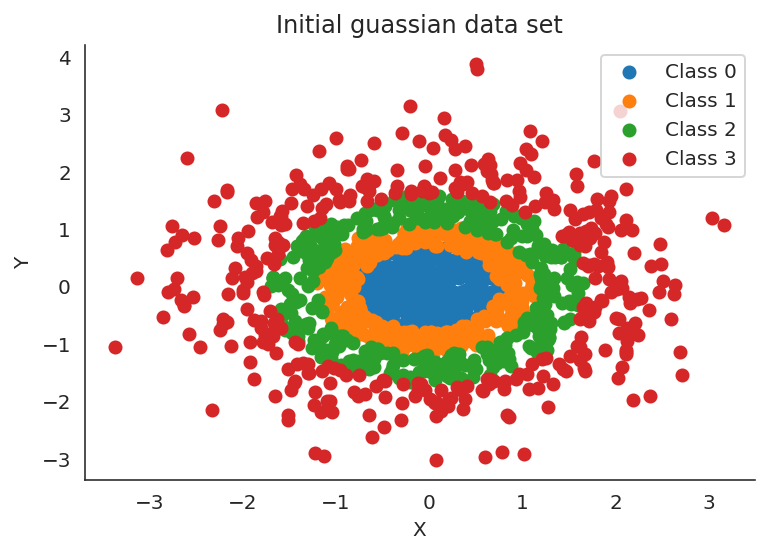

In [4]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], label="Class 1")
ax.scatter(X[Y == 2, 0], X[Y == 2, 1], label='Class 2')
ax.scatter(X[Y == 3, 0], X[Y == 3, 1], label='Class 3')
sns.despine()
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Initial guassian data set");

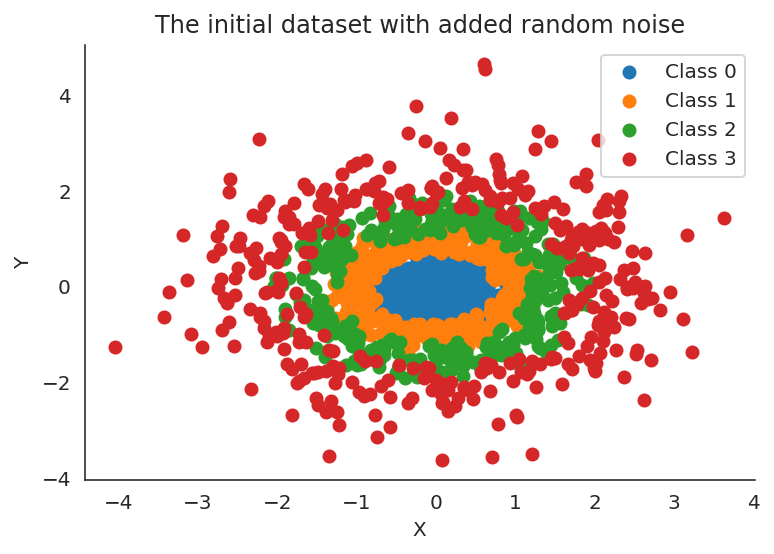

In [5]:
def add_noise(X, noise_coef):
    for i in range(len(X)):
        if random.randint(0, 1) == 1:
            X[i][0] += X[i][0]*noise_coef
            X[i][1] += X[i][1]*noise_coef 
            
add_noise(X, noise_coef=0.2)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], label='Class 1')
ax.scatter(X[Y==2, 0], X[Y==2, 1], label='Class 2')
ax.scatter(X[Y==3, 0], X[Y==3, 1], label='Class 3')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='The initial dataset with added random noise');


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [7]:
def bayesian_nn(ann_input, ann_output):
    n_hidden = 6
    # Weights between layers
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_3 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_4 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as bayesian_neural_network:
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)

        # Weights from input to output layer
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        weights_2_3 = pm.Normal("w_2_3", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_3)
        weights_3_4 = pm.Normal("w_3_4", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_4)
        weights_4_out = pm.Normal("w_4_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_3 = pm.math.tanh(pm.math.dot(act_2, weights_2_3))
        act_4 = pm.math.tanh(pm.math.dot(act_3, weights_3_4))
        act_out = pm.math.sigmoid(pm.math.dot(act_4, weights_4_out))

        out = pm.Poisson(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0])
    return bayesian_neural_network

bayesian_neural_network = bayesian_nn(X_train, Y_train)

In [8]:
from theano.sandbox import rng_mrg
pm.set_tt_rng(rng_mrg.MRG_RandomStream(42))

In [9]:
# %%time
with bayesian_neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 2,296.3


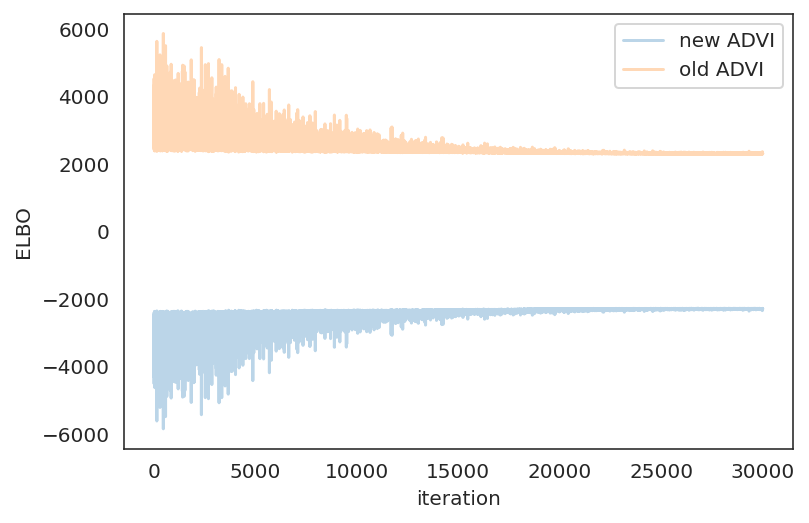

In [10]:
plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [11]:
trace = approx.sample(draws=5000)

In [12]:
bayesian_neural_network.out.distribution.data

ann_output

In [13]:
x = T.matrix("X")
n = T.iscalar("n")
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    bayesian_neural_network.out.distribution.data, size=n, more_replacements={bayesian_neural_network["ann_input"]: x})

sample_proba = theano.function([x, n], _sample_proba,on_unused_input='ignore')

def production_step1():
    pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=bayesian_neural_network)
    ppc = pm.sample_posterior_predictive(
        trace, samples=500, progressbar=False, model=bayesian_neural_network)
    pred = ppc["out"].mean(axis=0) > 0.5

def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

In [14]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

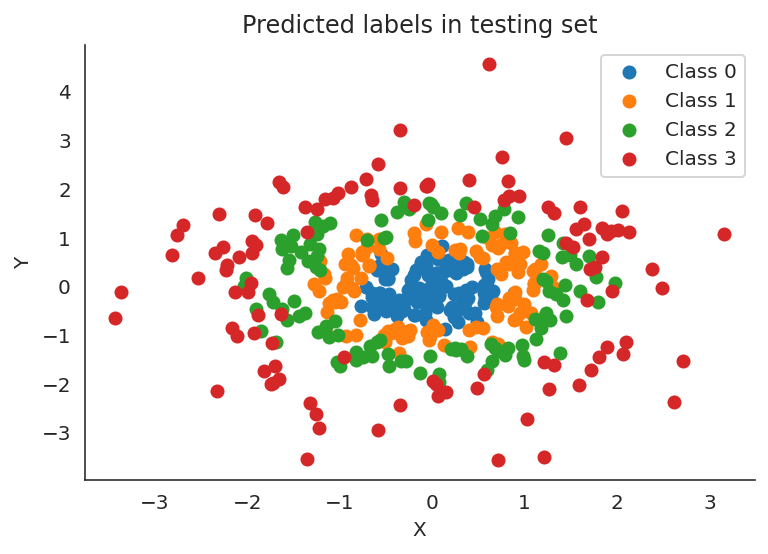

In [15]:
fig, ax = plt.subplots()
ax.scatter(X_test[Y_test == 0, 0], X_test[Y_test == 0, 1], label='Class 0')
ax.scatter(X_test[Y_test == 1, 0], X_test[Y_test == 1, 1], label='Class 1')
ax.scatter(X_test[Y_test == 2, 0], X_test[Y_test == 2, 1], label='Class 2')
ax.scatter(X_test[Y_test == 3, 0], X_test[Y_test == 3, 1], label='Class 3')
sns.despine();ax.legend()
ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y");

In [16]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [17]:
ppc = sample_proba(grid_2d, 500)

In [18]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = bayesian_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

Finished [100%]: Average Loss = 2,295.8


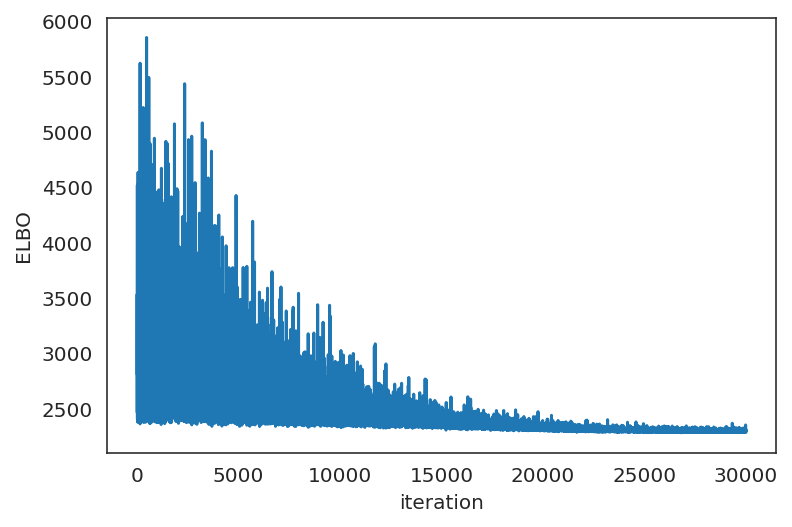

In [19]:
plt.plot(inference.hist)
plt.ylabel("ELBO")
plt.xlabel("iteration");

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0ac3c43d0>,
      dtype=object)

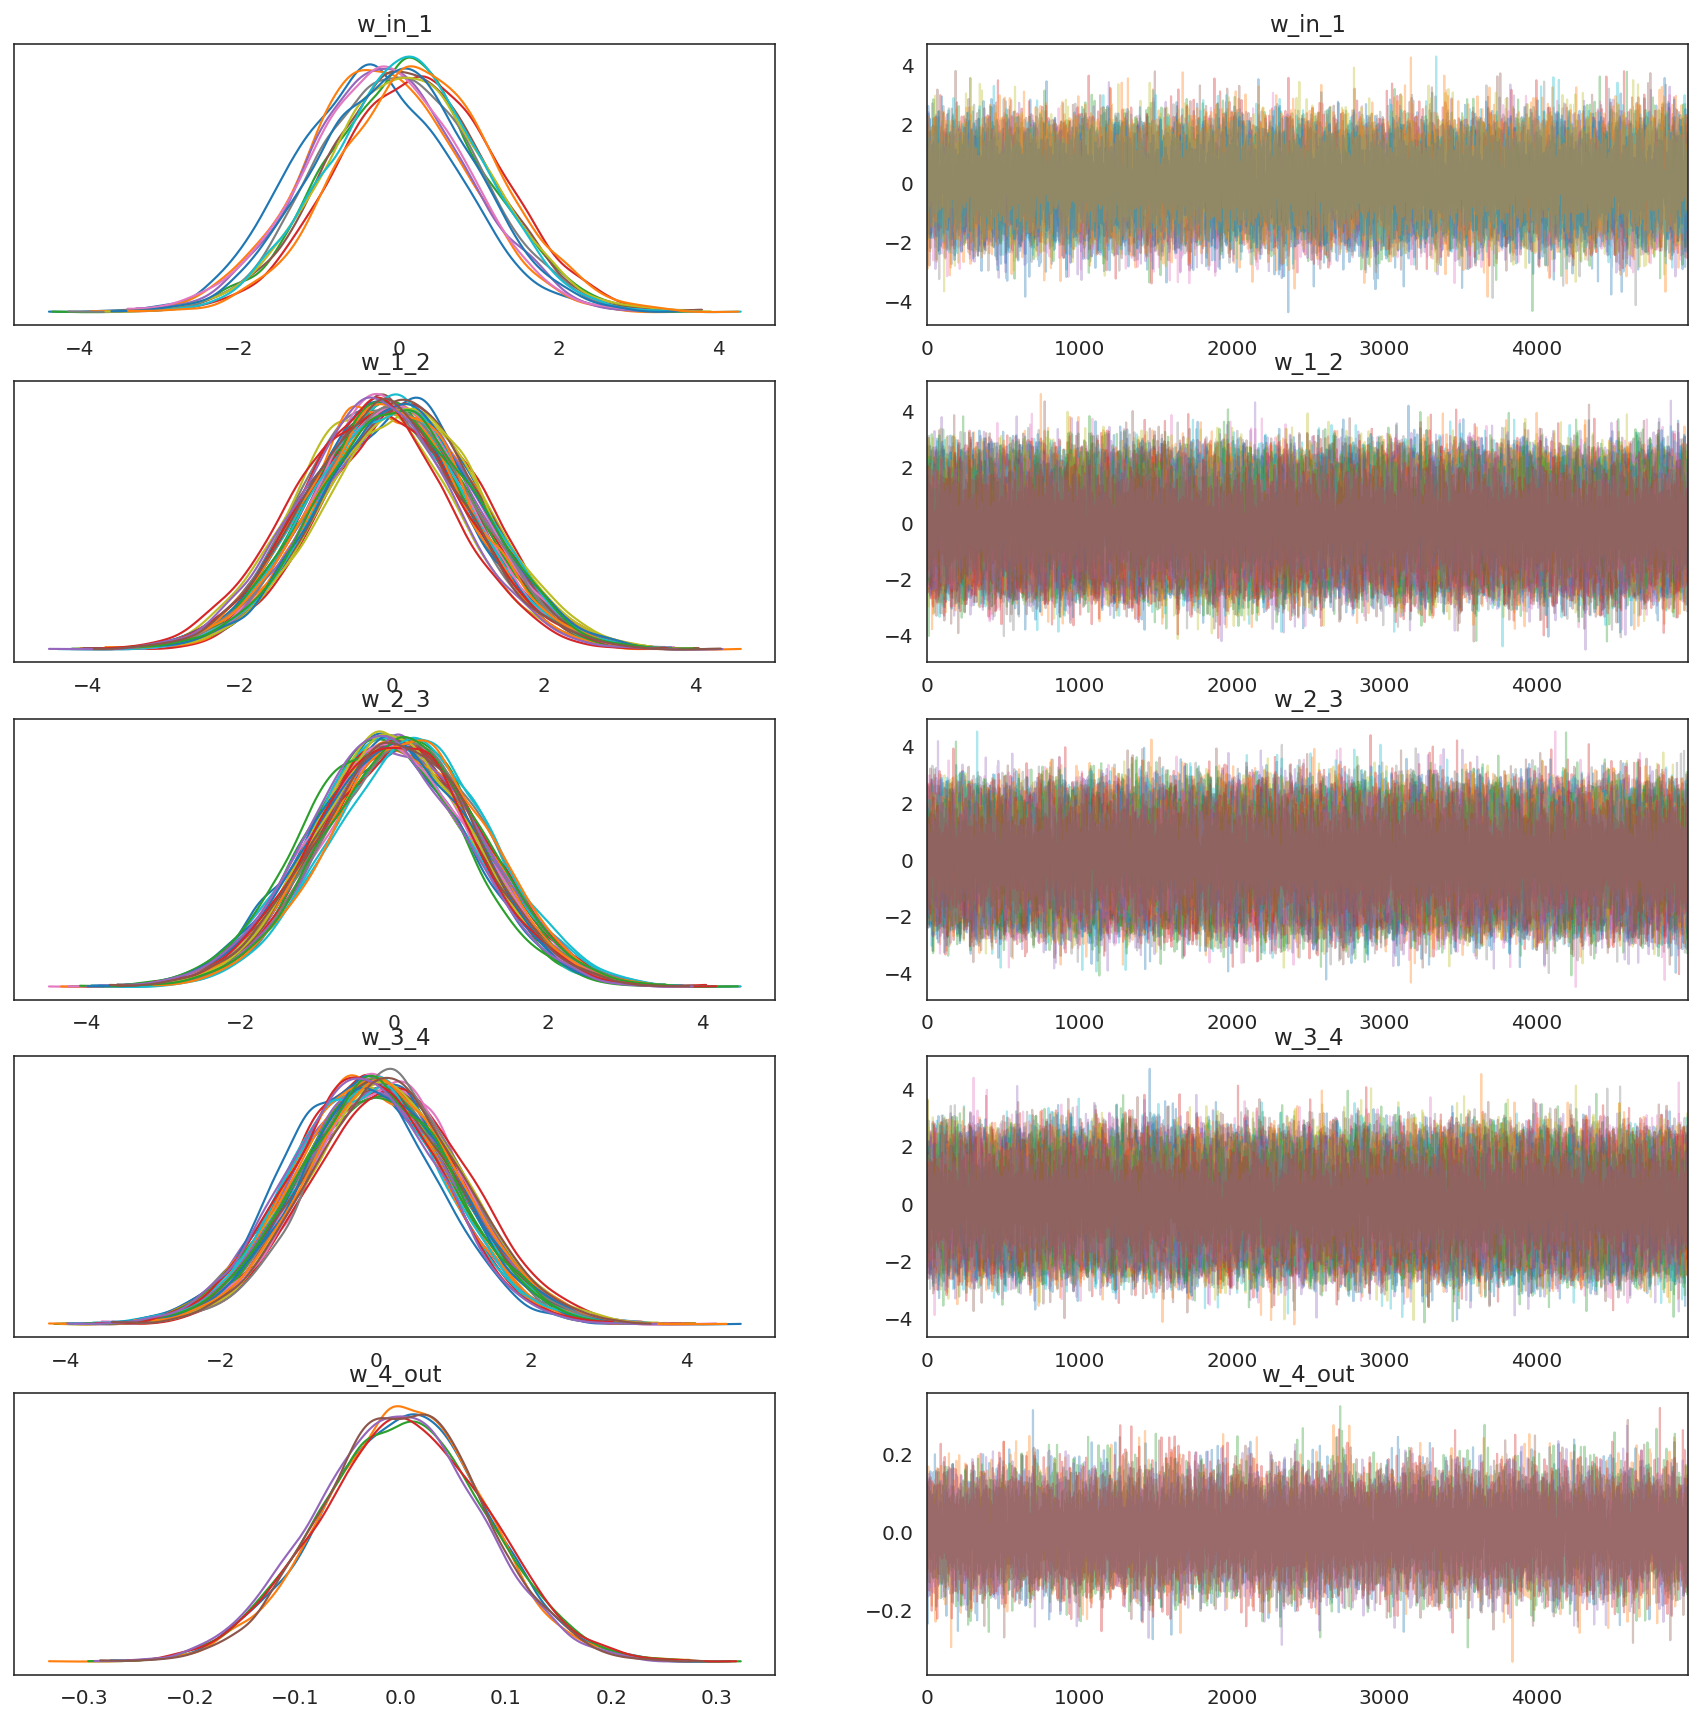

In [20]:
az.plot_trace(trace, figsize=(15,15))

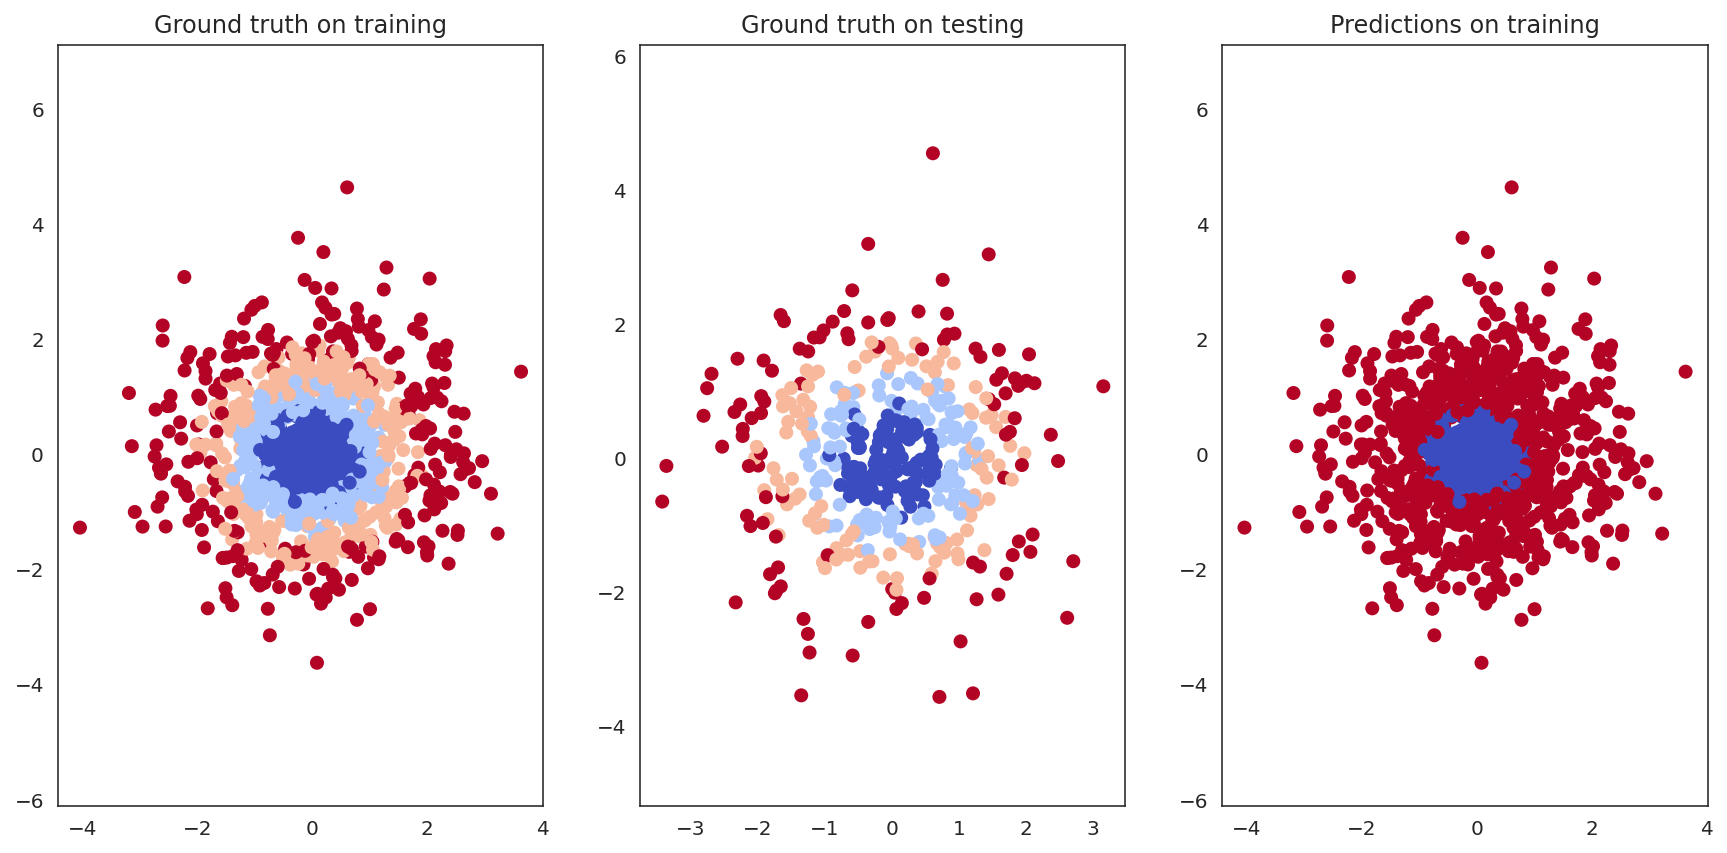

In [21]:
plt.figure(figsize=(20,7))
plt.subplot(141)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train ,cmap=cm.coolwarm)
plt.title('Ground truth on training')
plt.axis('equal');

plt.subplot(142)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test ,cmap=cm.coolwarm)
plt.title('Ground truth on testing')
plt.axis('equal');

plt.subplot(143)
plt.scatter(X_train[:,0], X_train[:,1], c=pred ,cmap=cm.coolwarm)
plt.title('Predictions on training')
plt.axis('equal');

In [22]:
pred = np.vectorize(pred)
pred = int(pred == True)
print("Accuracy = {}%".format((Y_test == pred).mean() * 100))

Accuracy = 25.11111111111111%
